Library


In [41]:
import math
import joblib
import numpy as np
import scipy.signal
import scipy.fftpack
import librosa
import soundfile as sf
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import matplotlib.pyplot as plt
from scipy.signal import resample_poly

Konstanta


In [42]:
SAMPLE_RATE = 48000
SEGMENT_DURATION = int(1 * SAMPLE_RATE)
OVERLAP_DURATION = int(0.5 * SAMPLE_RATE)

Random Seed


In [43]:
RANDOM_SEED = 21

try:
    from sklearn.utils import check_random_state
    random_state = check_random_state(RANDOM_SEED)
except ImportError:
    pass

# Pra-Pemrosesan


In [44]:
def load_file_audio(path):
    audio, sr = sf.read(path)
    return np.array(audio), sr

def prapemrosesan_downmixing(audio):
    if audio.ndim > 1:
        audio = np.mean(audio, axis=1)
    return audio.astype(np.float32)

def prapemrosesan_resampling(audio, sr):
    if sr == SAMPLE_RATE:
        return audio.copy(), SAMPLE_RATE
    
    ratio = SAMPLE_RATE / sr
    n_samples = int(np.round(len(audio) * ratio))
    
    x_old = np.linspace(0, 1, len(audio))
    x_new = np.linspace(0, 1, n_samples)
    return np.interp(x_new, x_old, audio), SAMPLE_RATE

def prapemrosesan_padding(audio):
    if np.mod(audio.shape[0], SEGMENT_DURATION) != 0:
        padding = SEGMENT_DURATION - (audio.shape[0] % SEGMENT_DURATION)
        audio = np.pad(audio, (0, padding))
    return audio

def prapemrosesan_splitting(audio):
    num_segments = int(np.floor((len(audio) - SEGMENT_DURATION) / OVERLAP_DURATION)) + 1
    segments = []

    for i in range(num_segments):
        start = int(i * OVERLAP_DURATION)
        end = int(start + SEGMENT_DURATION)
        segment = audio[start:end]
        if len(segment) < SEGMENT_DURATION:
            segment = np.pad(segment, (0, SEGMENT_DURATION - len(segment)), mode='constant')
        segments.append(segment)

    return np.array(segments)

# Ekstraksi Fitur


In [45]:
def get_rms(segment):
    return np.sqrt(np.mean(segment ** 2))

def get_zcr(segment):
    return np.sum(np.abs(np.diff(np.signbit(segment)))) / (len(segment) / SAMPLE_RATE)

def get_lms(segment):
    mel_spec = librosa.feature.melspectrogram(y=segment, sr=SAMPLE_RATE)
    return np.mean(mel_spec)

# Fuzzy Inference System


## Mamdani


In [46]:
def sistem_fuzzy_mamdani():
    # Adjusted ranges based on statistical values
    rms = ctrl.Antecedent(np.arange(0, 0.2, 0.001), 'rms')   # Max RMS ~0.18
    zcr = ctrl.Antecedent(np.arange(0, 15000, 10), 'zcr')    # Max ZCR ~14626
    output = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'output')

    # RMS Membership Functions (based on mean & std)
    rms['low'] = fuzz.sigmf(rms.universe, 0.04, -50)       # ~mean - std
    rms['medium'] = fuzz.gaussmf(rms.universe, 0.06, 0.02) # ~mean + small spread
    rms['high'] = fuzz.sigmf(rms.universe, 0.1, 50)        # ~mean + 2*std

    # ZCR Membership Functions
    zcr['infrequent'] = fuzz.sigmf(zcr.universe, 5000, -0.05)
    zcr['moderate'] = fuzz.gaussmf(zcr.universe, 8000, 2000)
    zcr['frequent'] = fuzz.sigmf(zcr.universe, 11000, 0.05)

    # Output
    output['not_loud'] = fuzz.sigmf(output.universe, 0.4, -20)
    output['loud'] = fuzz.sigmf(output.universe, 0.6, 20)

    # Rules (unchanged, still valid)
    rules = [
        ctrl.Rule(rms['low'] & zcr['infrequent'], output['not_loud']),
        ctrl.Rule(rms['low'] & zcr['moderate'], output['not_loud']),
        ctrl.Rule(rms['low'] & zcr['frequent'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['infrequent'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['moderate'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['frequent'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['infrequent'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['moderate'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['frequent'], output['loud'])
    ]

    system = ctrl.ControlSystem(rules)
    return system

def fuzzy_mamdani(rms_val, zcr_val, system=None):
    if system is None:
        system = sistem_fuzzy_mamdani()
    sim = ctrl.ControlSystemSimulation(system)
    sim.input['rms'] = rms_val
    sim.input['zcr'] = zcr_val
    try:
        sim.compute()
        return int(round(sim.output['output']))
    except:
        return 0  # Default if computation fails

## Sugeno


In [47]:
def sistem_fuzzy_sugeno():
    # Adjusted ranges
    rms = ctrl.Antecedent(np.arange(0, 0.2, 0.001), 'rms')
    zcr = ctrl.Antecedent(np.arange(0, 15000, 10), 'zcr')
    output = ctrl.Consequent(np.arange(0, 1.1, 0.01), 'output', defuzzify_method='centroid')

    # RMS Membership
    rms['low'] = fuzz.sigmf(rms.universe, 0.04, -50)
    rms['medium'] = fuzz.gaussmf(rms.universe, 0.06, 0.02)
    rms['high'] = fuzz.sigmf(rms.universe, 0.1, 50)

    # ZCR Membership
    zcr['infrequent'] = fuzz.sigmf(zcr.universe, 5000, -0.05)
    zcr['moderate'] = fuzz.gaussmf(zcr.universe, 8000, 2000)
    zcr['frequent'] = fuzz.sigmf(zcr.universe, 11000, 0.05)

    # Sugeno singleton outputs
    output['not_loud'] = 0.0
    output['loud'] = 1.0

    # Rules
    rules = [
        ctrl.Rule(rms['low'] & zcr['infrequent'], output['not_loud']),
        ctrl.Rule(rms['low'] & zcr['moderate'], output['not_loud']),
        ctrl.Rule(rms['low'] & zcr['frequent'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['infrequent'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['moderate'], output['not_loud']),
        ctrl.Rule(rms['medium'] & zcr['frequent'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['infrequent'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['moderate'], output['loud']),
        ctrl.Rule(rms['high'] & zcr['frequent'], output['loud'])
    ]

    system = ctrl.ControlSystem(rules)
    return system

def fuzzy_sugeno(rms_val, zcr_val, system=None):
    if system is None:
        system = sistem_fuzzy_sugeno()
    sim = ctrl.ControlSystemSimulation(system)
    sim.input['rms'] = rms_val
    sim.input['zcr'] = zcr_val
    try:
        sim.compute()
        return int(round(sim.output['output']))
    except:
        return 0

# Supervised Model


In [48]:
# # LGBM
# lgbm_path = r""
# model_lgbm = joblib.load(lgbm_path)

# # CNN
# cnn_path = r""
# model_cnn = joblib.load(cnn_path)

# # Conformer
# conformer_path = r""
# model_conformer = joblib.load(conformer_path)

# Visualization


In [54]:
def plot_audio_with_loud_segments(audio_path, list_result):
    audio, sr = load_file_audio(audio_path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    
    time_axis = np.linspace(0, len(audio) / SAMPLE_RATE, len(audio))
    
    plt.figure(figsize=(14, 4))
    plt.plot(time_axis, audio, label="Amplitude")
    plt.title("Audio waveform with loud segments marked")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    
    for i, (out, _, _) in enumerate(list_result):
        if out == 1:
            start_time = i * (SEGMENT_DURATION / SAMPLE_RATE)
            end_time = start_time + (SEGMENT_DURATION / SAMPLE_RATE)
            plt.axvspan(start_time, end_time, color='red', alpha=0.3)
    
    plt.tight_layout()
    plt.legend()
    plt.show()

# Main


## Single Audio Inference


In [50]:
def single_inference(path, fis, sm):
    audio, sr = load_file_audio(path)
    audio = prapemrosesan_downmixing(audio)
    audio, sr = prapemrosesan_resampling(audio, sr)
    audio = prapemrosesan_padding(audio)
    segments = prapemrosesan_splitting(audio)
    
    list_result = []
    for segment in segments:
        rms = get_rms(segment)
        zcr = get_zcr(segment)
        
        if fis == "mamdani":
            out = fuzzy_mamdani(rms, zcr)
        else:
            out = fuzzy_sugeno(rms, zcr)
                
        # if out != 2:
        #     spec = get_lms(segment)
        #     if sm == "lgbm":
        #         out = model_lgbm(spec)
        #     else sm == "cnn":
        #         out = model_cnn(spec)
        #     else:
        #         out = model_conformer(spec)
        
        list_result.append((out, round(rms, 5), round(zcr, 5)))
    
    return list_result

# Execution


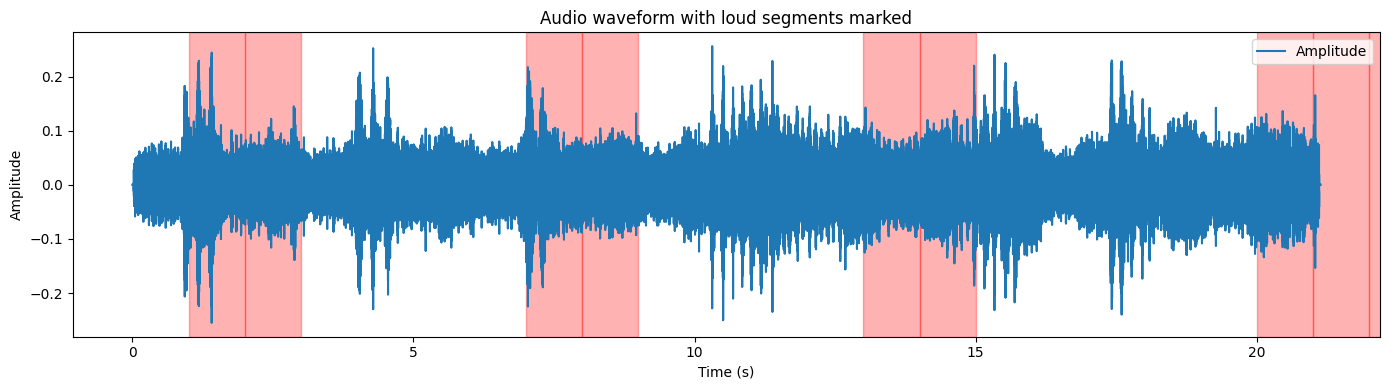

In [57]:
# audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\noise-audio-data\1-7974-B-49.wav"
audio_path = r"C:\Users\Lulay\Documents\GitHub\Dasar-Kecerdasan-Artificial_Tugas-Besar\Dataset\xeno-canto\498380.mp3"
option_fis = "mamdani"
option_sm = "cnn"

hasil_inferensi = single_inference(audio_path, option_fis, option_sm)
plot_audio_with_loud_segments(audio_path, hasil_inferensi)